In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Path to the dataset file
dataset_path = '/content/drive/MyDrive/Credit_Card_Fraud_Detection/credit_card_transactions.csv'

# Check if the file exist
if os.path.exists(dataset_path):
  print("The pre-processed dataset file is present.")
else:
  print("The pre-processed dataset file is not present.")

The pre-processed dataset file is present.


In [ ]:
# All imports and utility functions
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split

df = pd.read_csv(dataset_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

# Data Pre-processing

In [ ]:
'''
Drop the columns
 1) which are not useful for fraud detection or
 2) have high correlations
'''
df.drop("Unnamed: 0", inplace=True, axis=1)
df.drop("gender", inplace=True, axis=1)
df.drop("first", inplace=True, axis=1)
df.drop("last", inplace=True, axis=1)
df.drop("lat", inplace=True, axis=1) # Almost same as merch_lat
df.drop("long", inplace=True, axis=1) # Almost same as merch_long
df.drop("dob", inplace=True, axis=1)
df.drop("job", inplace=True, axis=1)
df.drop("merch_zipcode", inplace=True, axis=1) # Because we have another zip code also
df.drop("merch_lat", inplace=True, axis=1)
df.drop("merch_long", inplace=True, axis=1)
df.drop("street", inplace=True, axis=1)
df.drop("city_pop", inplace=True, axis=1)
df.drop("trans_date_trans_time", inplace=True, axis=1) # Becuase we have unix_time
df.drop("trans_num", inplace=True, axis=1)
df.drop('city', inplace=True, axis=1)
df.drop('state', inplace=True, axis=1)

print(df.columns)
df.dtypes

Index(['cc_num', 'merchant', 'category', 'amt', 'zip', 'unix_time',
       'is_fraud'],
      dtype='object')


,0
cc_num,int64
merchant,object
category,object
amt,float64
zip,int64
unix_time,int64
is_fraud,int64


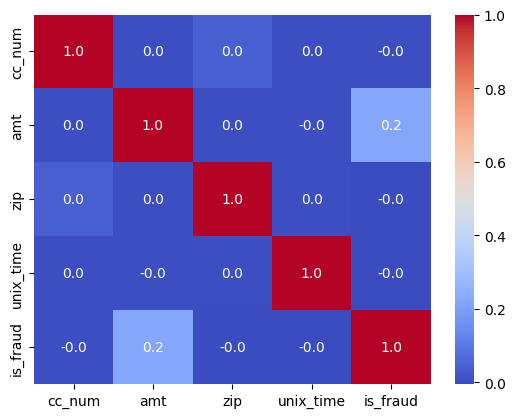

In [ ]:
# Check the correlations again among attributes
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.1f', cmap='coolwarm')
plt.show()

In [ ]:
# Use onehot encoding for the categorical data (merchant, category)
df = pd.get_dummies(df, columns=['merchant', 'category'])

df.head()

,cc_num,amt,zip,unix_time,is_fraud,merchant_fraud_Abbott-Rogahn,merchant_fraud_Abbott-Steuber,merchant_fraud_Abernathy and Sons,merchant_fraud_Abshire PLC,"merchant_fraud_Adams, Kovacek and Kuhlman",...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
0,2703186189652095,4.97,28654,1325376018,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,630423337322,107.23,99160,1325376044,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,38859492057661,220.11,83252,1325376051,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3534093764340240,45.00,59632,1325376076,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,375534208663984,41.96,24433,1325376186,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
# See if no categorical attributes are left
df.dtypes

,0
cc_num,int64
amt,float64
zip,int64
unix_time,int64
is_fraud,int64
...,...
category_misc_pos,uint8
category_personal_care,uint8
category_shopping_net,uint8
category_shopping_pos,uint8


In [ ]:
# Let's fix the class imbalance first using SMOTE
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

smote = SMOTE()
X,y = smote.fit_resample(X,y)

In [ ]:
# Split the data for train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Number of fraud transactions in the training datset:\n", y_train.value_counts())
print("\nNumber of fraud transactions in the testing dataset:\n", y_test.value_counts())
X.head()

Number of fraud transactions in the training datset:
 0    1031335
1    1031335
Name: is_fraud, dtype: int64

Number of fraud transactions in the testing dataset:
 1    257834
0    257834
Name: is_fraud, dtype: int64


,cc_num,amt,zip,unix_time,merchant_fraud_Abbott-Rogahn,merchant_fraud_Abbott-Steuber,merchant_fraud_Abernathy and Sons,merchant_fraud_Abshire PLC,"merchant_fraud_Adams, Kovacek and Kuhlman",merchant_fraud_Adams-Barrows,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
0,2703186189652095,4.97,28654,1325376018,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,630423337322,107.23,99160,1325376044,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,38859492057661,220.11,83252,1325376051,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3534093764340240,45.00,59632,1325376076,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,375534208663984,41.96,24433,1325376186,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


We can see that now both the classes are balanced.

# Model Development and Validation

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train, y_train)

lr_y_pred = lr_model.predict(X_test)

In [ ]:
print("===== Logistic Regression ======")
print("Accuracy:", accuracy_score(y_test, lr_y_pred))
print("Precision:", precision_score(y_test, lr_y_pred, average='weighted', zero_division=1))
print("Recall:", recall_score(y_test, lr_y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, lr_y_pred, average='weighted'))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, lr_y_pred))

print("\nClassification Report:")
print(classification_report(y_test, lr_y_pred, zero_division=0))

===== Logistic Regression ======
Accuracy: 0.5
Precision: 0.75
Recall: 0.5
F1 Score: 0.3333333333333333

Confusion Matrix:
[[257834      0]
 [257834      0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67    257834
           1       0.00      0.00      0.00    257834

    accuracy                           0.50    515668
   macro avg       0.25      0.50      0.33    515668
weighted avg       0.25      0.50      0.33    515668



We can see that **Logistic Regression is not a good choice for this exercise.**

We had also tried Logistic Regression with Kernel PCA. But the issue we faced is the available amount of RAM since KPCA memory requirement gorws quadratic of the data points available in the dataset. In our case we have around 1.3M rows and hence it is difficult to work with KPCA.


## Random Forest Classifier

Increasing the n_estimators increses the validation scores, but that causes more execution time. So, to balance it, we are keeping it to 20

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=20, min_samples_leaf=4, max_depth=20, min_samples_split=4, random_state=0)
rf_model.fit(X_train, y_train)

rf_y_pred = rf_model.predict(X_test)

In [ ]:
print("===== RandomForest Classifier ======")
print(f"Accuracy: {accuracy_score(y_test, rf_y_pred):.3f}")
print(f"Precision: {precision_score(y_test, rf_y_pred, average='weighted', zero_division=0):.3f}")
print(f"Recall: {recall_score(y_test, rf_y_pred, average='weighted'):.3f}")
print(f"F1 Score: {f1_score(y_test, rf_y_pred, average='weighted'):.3f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, rf_y_pred))

print("\nClassification Report:")
print(classification_report(y_test, rf_y_pred, zero_division=0))

===== RandomForest Classifier ======
Accuracy: 0.911
Precision: 0.917
Recall: 0.911
F1 Score: 0.910

Confusion Matrix:
[[251228   6606]
 [ 39434 218400]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.92    257834
           1       0.97      0.85      0.90    257834

    accuracy                           0.91    515668
   macro avg       0.92      0.91      0.91    515668
weighted avg       0.92      0.91      0.91    515668



The Type-I and Type-II error with RandomForestClassifier **is more** with n_estimators=20.

Also, the Precision, Recall, and f-1 scores are okay but not that good.

So RandomForest is somewhat okay

## Random Forest Classifier with PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

'''
Standardize the data becuase PCA is sensitive to the scale of features.
Features should be on the same scale (mean of 0 and standard deviation of 1).

X is alraedy after dropping some of the attributes and one-hot encoding on
two attributes becuase, categorical data were many and one-hot encoding on all
of them would have resulted in far too many columns.
'''
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95) # 95% of variance
X_pca = pca.fit_transform(X_scaled)
print("Number of components selected:", pca.n_components_)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=1)

# Use RandomForest as ensemble method with PCA
rf_model_pca = RandomForestClassifier(n_estimators=20, min_samples_leaf=4, max_depth=20, min_samples_split=4, random_state=0)
rf_model_pca.fit(X_train_pca, y_train_pca)

rf_y_pred_pca = rf_model_pca.predict(X_test_pca)

Number of components selected: 662


In [ ]:
print("===== RandomForest Classifier with PCA ======")
print(f"Accuracy: {accuracy_score(y_test_pca, rf_y_pred_pca):.3f}")
print(f"Precision: {precision_score(y_test_pca, rf_y_pred_pca, average='weighted', zero_division=0):.3f}")
print(f"Recall: {recall_score(y_test_pca, rf_y_pred_pca, average='weighted'):.3f}")
print(f"F1 Score: {f1_score(y_test_pca, rf_y_pred_pca, average='weighted'):.3f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_pca, rf_y_pred_pca))

print("\nClassification Report:")
print(classification_report(y_test_pca, rf_y_pred_pca, zero_division=0))

===== RandomForest Classifier with PCA ======
Accuracy: 0.992
Precision: 0.992
Recall: 0.992
F1 Score: 0.992

Confusion Matrix:
[[256652    545]
 [  3818 254653]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    257197
           1       1.00      0.99      0.99    258471

    accuracy                           0.99    515668
   macro avg       0.99      0.99      0.99    515668
weighted avg       0.99      0.99      0.99    515668



We can see that with same n_estimators=20 and max_depth=20, the RandomForestClassifier with PCA is giving better result compared to standalone RandomForestClassifier.
 - Type-I error is less
 - Type-II error is very less

## Decision Tree Classifier

Increasing the max_depth increases the scores, so as execution time. With max_depth=20, the scores are already closed to 99%

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(max_depth=20, min_samples_split=4, random_state=0)
dt_model.fit(X_train, y_train)

dc_y_pred = dt_model.predict(X_test)

In [ ]:
print("===== DecisionTree Classifier ======")
print(f"Accuracy: {accuracy_score(y_test, dc_y_pred):.3f}")
print(f"Precision: {precision_score(y_test, dc_y_pred, average='weighted', zero_division=0):.3f}")
print(f"Recall: {recall_score(y_test, dc_y_pred, average='weighted'):.3f}")
print(f"F1 Score: {f1_score(y_test, dc_y_pred, average='weighted'):.3f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, dc_y_pred))

print("\nClassification Report:")
print(classification_report(y_test, dc_y_pred, zero_division=0))

===== DecisionTree Classifier ======
Accuracy: 0.993
Precision: 0.993
Recall: 0.993
F1 Score: 0.993

Confusion Matrix:
[[255954   1880]
 [  1646 256188]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    257834
           1       0.99      0.99      0.99    257834

    accuracy                           0.99    515668
   macro avg       0.99      0.99      0.99    515668
weighted avg       0.99      0.99      0.99    515668




The Type-I and Type-II error with DecisonTreeClassifier is **very less** (~ 1%).
 - Type-I error (FP) is **less** than RandomForestClassifier with PCA
 - Type-II error (FN) is **more** than RandomForestClassifier with PCA

Also, the Precision, Recall, and f-1 **scores are very good**.


## Gradient Boost Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(n_estimators=20, learning_rate=0.1, max_depth=4, random_state=0)
gb_model.fit(X_train, y_train)

gb_y_pred = gb_model.predict(X_test)

In [ ]:
print("===== GradientBoost Classifier ======")
print(f"Accuracy: {accuracy_score(y_test, gb_y_pred):.3f}")
print(f"Precision: {precision_score(y_test, gb_y_pred, average='weighted', zero_division=0):.3f}")
print(f"Recall: {recall_score(y_test, gb_y_pred, average='weighted'):.3f}")
print(f"F1 Score: {f1_score(y_test, gb_y_pred, average='weighted'):.3f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, gb_y_pred))

print("\nClassification Report:")
print(classification_report(y_test, gb_y_pred, zero_division=0))

===== GradientBoost Classifier ======
Accuracy: 0.904
Precision: 0.911
Recall: 0.904
F1 Score: 0.903

Confusion Matrix:
[[250310   7524]
 [ 42216 215618]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91    257834
           1       0.97      0.84      0.90    257834

    accuracy                           0.90    515668
   macro avg       0.91      0.90      0.90    515668
weighted avg       0.91      0.90      0.90    515668



## k-fold Cross Validation with Random Forest Classification Model



In [ ]:
from sklearn.model_selection import KFold, cross_val_score

k = 5 # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

scores = cross_val_score(rf_model, X, y, cv=kf, scoring='accuracy')
print(f'Cross Validation Accuracy: {scores.mean():.3f} (+/-{scores.std():0.3f})')


Cross Validation Accuracy: 0.896 (+/-0.006)


The accuracy of k-fold cross validation with RandomForestClassifier is almost same as RandomForestClassifier only.

Not trying k-fold with DecisionTreeClassifier, as accuracy of that is already good.

# Plotting graphs

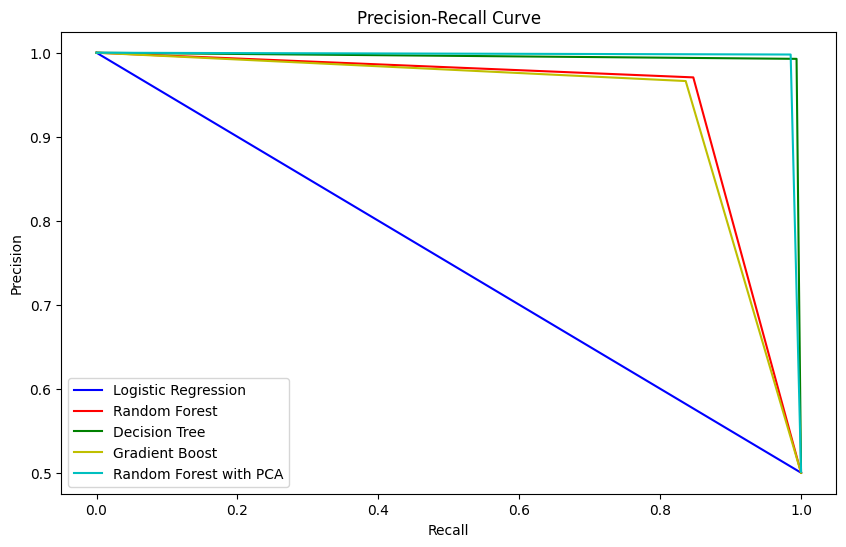

In [ ]:
# Plot Precision-Recall Curve
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_y_pred)
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_y_pred)
dc_precision, dc_recall, _ = precision_recall_curve(y_test, dc_y_pred)
gb_precision, gb_recall, _ = precision_recall_curve(y_test, gb_y_pred)
rf_precision_pca, rf_recall_pca, _ = precision_recall_curve(y_test_pca, rf_y_pred_pca)

plt.figure(figsize=(10,6))
plt.plot(lr_recall, lr_precision, color = 'b', label='Logistic Regression')
plt.plot(rf_recall, rf_precision, color = 'r', label='Random Forest')
plt.plot(dc_recall, dc_precision, color = 'g', label='Decision Tree')
plt.plot(gb_recall, gb_precision, color = 'y', label='Gradient Boost')
plt.plot(rf_recall_pca, rf_precision_pca, color = 'c', label='Random Forest with PCA')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

LogisticRegression ROC-AUC Score: 0.5
RandomForest ROC-AUC Score: 0.9107177486289627
DecisionTree ROC-AUC Score: 0.9931622671951721
GradientBoost ROC-AUC Score: 0.9035425894179977
RandomForest ROC-AUC Score: 0.991554759327341


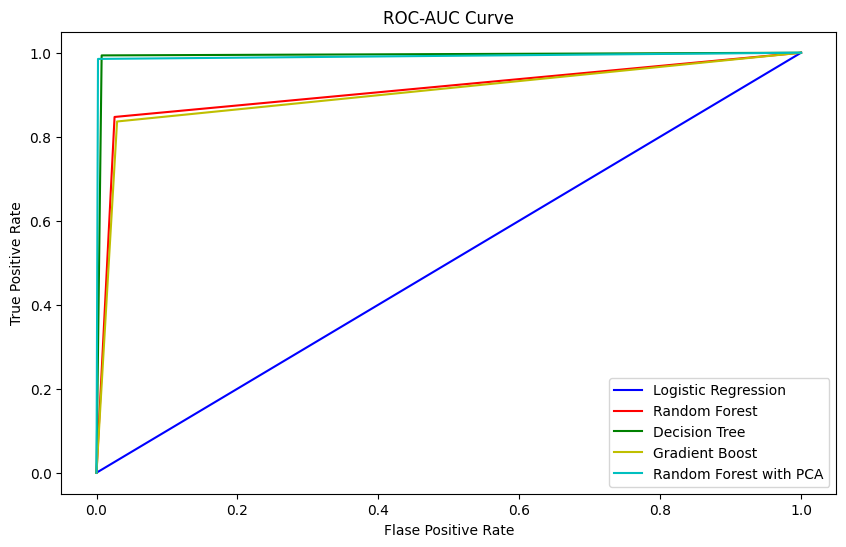

In [ ]:
# Plot the ROC-AUC Curve
from sklearn.metrics import roc_auc_score, roc_curve
lr_roc_auc = roc_auc_score(y_test, lr_y_pred)
rf_roc_auc = roc_auc_score(y_test, rf_y_pred)
dc_roc_auc = roc_auc_score(y_test, dc_y_pred)
gb_roc_auc = roc_auc_score(y_test, gb_y_pred)
rf_roc_auc_pca = roc_auc_score(y_test_pca, rf_y_pred_pca)

print("LogisticRegression ROC-AUC Score:", lr_roc_auc)
print("RandomForest ROC-AUC Score:", rf_roc_auc)
print("DecisionTree ROC-AUC Score:", dc_roc_auc)
print("GradientBoost ROC-AUC Score:", gb_roc_auc)
print("RandomForest ROC-AUC Score:", rf_roc_auc_pca)

lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, lr_y_pred)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_y_pred)
dc_fpr, dc_tpr, dc_thresholds = roc_curve(y_test, dc_y_pred)
gb_fpr, gb_tpr, gb_thresholds = roc_curve(y_test, gb_y_pred)
rf_fpr_pca, rf_tpr_pca, rf_thresholds_pca = roc_curve(y_test_pca, rf_y_pred_pca)

plt.figure(figsize=(10,6))
plt.plot(lr_fpr, lr_tpr, color='b', label='Logistic Regression')
plt.plot(rf_fpr, rf_tpr, color='r', label='Random Forest')
plt.plot(dc_fpr, dc_tpr, color='g', label='Decision Tree')
plt.plot(gb_fpr, gb_tpr, color='y', label='Gradient Boost')
plt.plot(rf_fpr_pca, rf_tpr_pca, color='c', label='Random Forest with PCA')

plt.xlabel('Flase Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend()

From these graphs, it can be observed that:
 - **DecisionTree Classifier** and **RandomForestClassifier with PCA**, both are giving best results
 - RandomForest & GradientBoost are giving similar results
 - Logistic Regression is not a good choice for this problem as the data may not be linearly seperable.